In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from PIL import Image
import nibabel as nib
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
adc_images = []
dwi_images = []
masks = []
adc_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_2/img/adc"
dwi_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_2/img/dwi"
mask_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_2/mask"
for filename in os.listdir(adc_dir):
    if filename.endswith(".gz"):
        adc_path = os.path.join(adc_dir, filename)
        adc_img = nib.load(adc_path).get_fdata()
        adc_images.append(adc_img)
for filename in os.listdir(dwi_dir):
    if filename.endswith(".gz"):
        dwi_path = os.path.join(dwi_dir, filename)
        dwi_img = nib.load(dwi_path).get_fdata()
        dwi_images.append(dwi_img)
for filename in os.listdir(mask_dir):
    if filename.endswith(".gz"):
        mask_path = os.path.join(mask_dir, filename)
        mask_img = nib.load(mask_path).get_fdata()
        masks.append(mask_img)

In [3]:
adc_images[0].shape, dwi_images[0].shape, masks[0].shape

((64, 64), (64, 64), (64, 64))

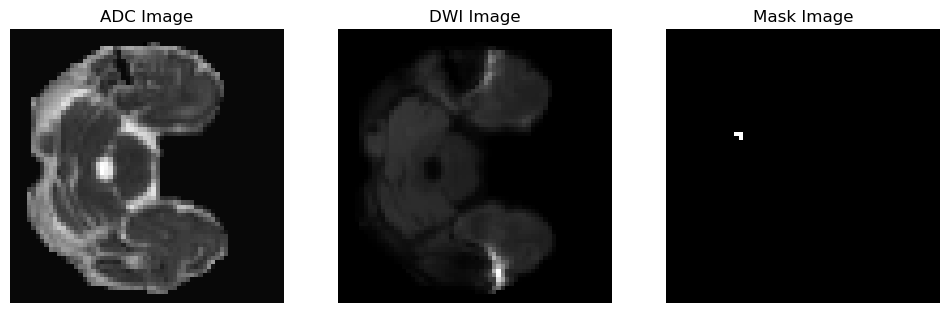

In [4]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(adc_images[0], cmap='gray')
plt.title('ADC Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(dwi_images[0], cmap='gray')
plt.title('DWI Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(masks[0], cmap='gray')
plt.title('Mask Image')
plt.axis('off')
plt.show()

In [5]:
adc_images = np.array(adc_images)
dwi_images = np.array(dwi_images)
masks = np.array(masks)
print(adc_images.shape, dwi_images.shape, masks.shape)

(1504, 64, 64) (1504, 64, 64) (1504, 64, 64)


In [6]:
X = np.stack((adc_images, dwi_images), axis=0)
y = masks[np.newaxis, ...]
print(X.shape, y.shape)

(2, 1504, 64, 64) (1, 1504, 64, 64)


In [7]:
import segmentation_models_pytorch as smp

/home/pritamk/miniconda3/envs/AIMIA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=2,
    classes=1
)

In [9]:
def normalize_data(X, y):
    X_norm = np.zeros_like(X)
    for i in range(X.shape[0]):  # For two channels
        X_norm[i] = (X[i] - X[i].min()) / (X[i].max() - X[i].min() + 1e-8)
    
    y_norm = (y > 0).astype(np.float32)
    
    return X_norm, y_norm

X_normalized, y_normalized = normalize_data(X, y)
print(f"Normalized X range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
print(f"Normalized y range: [{y_normalized.min():.3f}, {y_normalized.max():.3f}]")
print(f"Unique values in masks: {np.unique(y_normalized)}")


X_tensor = torch.FloatTensor(X_normalized).permute(1, 0, 2, 3)  # (samples, channels, H, W)
y_tensor = torch.FloatTensor(y_normalized).permute(1, 0, 2, 3)  # (samples, classes, H, W)

print(f"X tensor shape: {X_tensor.shape}")
print(f"y tensor shape: {y_tensor.shape}")

Normalized X range: [0.000, 1.000]
Normalized y range: [0.000, 1.000]
Unique values in masks: [0. 1.]
X tensor shape: torch.Size([1504, 2, 64, 64])
y tensor shape: torch.Size([1504, 1, 64, 64])


In [24]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)
print(f"Train shape {X_train.shape}, labels shape {y_train.shape}")

Train shape torch.Size([1052, 2, 64, 64]), labels shape torch.Size([1052, 1, 64, 64])


In [ ]:
model.to('cuda')

Image batch shape: torch.Size([16, 2, 64, 64]), Label batch shape: torch.Size([16, 1, 64, 64])
True


In [ ]:
def compute_metrics(preds, labels, threshold=0.5):
        preds = torch.sigmoid(preds)
        preds = (preds > threshold).float()

        intersection = (preds * labels).sum(dim=(1, 2, 3))
        union = (preds + labels - preds * labels).sum(dim=(1, 2, 3))
        dice = (2 * intersection) / (preds.sum(dim=(1, 2, 3)) + labels.sum(dim=(1, 2, 3)) + 1e-8)
        iou = (intersection + 1e-8) / (union + 1e-8)

        return iou.mean().item(), dice.mean().item()

In [149]:
import tqdm

def train_segmentation(train_loader, val_loader, criterion, scheduler, epochs, optimizer, model, device):
    train_losses, val_losses = [], []
    train_ious, val_ious = [], []
    train_dices, val_dices = [], []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss, train_iou, train_dice = 0.0, 0.0, 0.0

        for img, label in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            img = img.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            outputs = model(img)  # logits

            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * img.size(0)

            # Metrics
            batch_iou, batch_dice = compute_metrics(outputs.detach(), label)
            train_iou += batch_iou * img.size(0)
            train_dice += batch_dice * img.size(0)

        train_loss /= len(train_loader.dataset)
        train_iou /= len(train_loader.dataset)
        train_dice /= len(train_loader.dataset)

        train_losses.append(train_loss)
        train_ious.append(train_iou)
        train_dices.append(train_dice)

        model.eval()
        val_loss, val_iou, val_dice = 0.0, 0.0, 0.0

        with torch.no_grad():
            for img, label in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                img = img.to(device, dtype=torch.float32)
                label = label.to(device, dtype=torch.float32)

                outputs = model(img)  # logits
                loss = criterion(outputs, label)
                val_loss += loss.item() * img.size(0)

                batch_iou, batch_dice = compute_metrics(outputs, label)
                val_iou += batch_iou * img.size(0)
                val_dice += batch_dice * img.size(0)

        val_loss /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)

        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_dices.append(val_dice)

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
              f"Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f} | "
              f"Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_ious": train_ious,
        "val_ious": val_ious,
        "train_dices": train_dices,
        "val_dices": val_dices,
    }


In [150]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [151]:
history = train_segmentation(train_loader, val_loader, criterion, scheduler, epochs=30, optimizer=optimizer, model=model, device='cuda')

Epoch 1/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 180.44it/s]


Epoch [1/30] | Train Loss: 0.0236, Val Loss: 0.0290 | Train IoU: 0.3789, Val IoU: 0.3554 | Train Dice: 0.3130, Val Dice: 0.2536


Epoch 2/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 182.59it/s]


Epoch [2/30] | Train Loss: 0.0235, Val Loss: 0.0289 | Train IoU: 0.3803, Val IoU: 0.3571 | Train Dice: 0.3132, Val Dice: 0.2504


Epoch 3/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 183.46it/s]


Epoch [3/30] | Train Loss: 0.0235, Val Loss: 0.0290 | Train IoU: 0.3861, Val IoU: 0.3554 | Train Dice: 0.3180, Val Dice: 0.2544


Epoch 4/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.77it/s]


Epoch [4/30] | Train Loss: 0.0239, Val Loss: 0.0293 | Train IoU: 0.3796, Val IoU: 0.3560 | Train Dice: 0.3127, Val Dice: 0.2433


Epoch 5/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.69it/s]


Epoch [5/30] | Train Loss: 0.0235, Val Loss: 0.0293 | Train IoU: 0.3828, Val IoU: 0.3500 | Train Dice: 0.3172, Val Dice: 0.2417


Epoch 6/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 181.07it/s]


Epoch [6/30] | Train Loss: 0.0232, Val Loss: 0.0291 | Train IoU: 0.3820, Val IoU: 0.3579 | Train Dice: 0.3169, Val Dice: 0.2522


Epoch 7/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.61it/s]


Epoch [7/30] | Train Loss: 0.0234, Val Loss: 0.0292 | Train IoU: 0.3777, Val IoU: 0.3579 | Train Dice: 0.3107, Val Dice: 0.2460


Epoch 8/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 185.13it/s]


Epoch [8/30] | Train Loss: 0.0236, Val Loss: 0.0292 | Train IoU: 0.3837, Val IoU: 0.3535 | Train Dice: 0.3222, Val Dice: 0.2463


Epoch 9/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 183.83it/s]


Epoch [9/30] | Train Loss: 0.0236, Val Loss: 0.0288 | Train IoU: 0.3836, Val IoU: 0.3610 | Train Dice: 0.3198, Val Dice: 0.2565


Epoch 10/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 185.21it/s]


Epoch [10/30] | Train Loss: 0.0233, Val Loss: 0.0290 | Train IoU: 0.3842, Val IoU: 0.3605 | Train Dice: 0.3183, Val Dice: 0.2553


Epoch 11/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 183.66it/s]


Epoch [11/30] | Train Loss: 0.0234, Val Loss: 0.0293 | Train IoU: 0.3836, Val IoU: 0.3540 | Train Dice: 0.3185, Val Dice: 0.2468


Epoch 12/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 185.21it/s]


Epoch [12/30] | Train Loss: 0.0234, Val Loss: 0.0293 | Train IoU: 0.3807, Val IoU: 0.3508 | Train Dice: 0.3149, Val Dice: 0.2436


Epoch 13/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.70it/s]


Epoch [13/30] | Train Loss: 0.0234, Val Loss: 0.0293 | Train IoU: 0.3792, Val IoU: 0.3615 | Train Dice: 0.3132, Val Dice: 0.2505


Epoch 14/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.29it/s]


Epoch [14/30] | Train Loss: 0.0233, Val Loss: 0.0288 | Train IoU: 0.3875, Val IoU: 0.3589 | Train Dice: 0.3186, Val Dice: 0.2539


Epoch 15/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.12it/s]


Epoch [15/30] | Train Loss: 0.0230, Val Loss: 0.0289 | Train IoU: 0.3855, Val IoU: 0.3546 | Train Dice: 0.3166, Val Dice: 0.2536


Epoch 16/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.37it/s]


Epoch [16/30] | Train Loss: 0.0234, Val Loss: 0.0292 | Train IoU: 0.3812, Val IoU: 0.3569 | Train Dice: 0.3164, Val Dice: 0.2503


Epoch 17/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 181.45it/s]


Epoch [17/30] | Train Loss: 0.0232, Val Loss: 0.0289 | Train IoU: 0.3831, Val IoU: 0.3579 | Train Dice: 0.3197, Val Dice: 0.2522


Epoch 18/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.12it/s]


Epoch [18/30] | Train Loss: 0.0231, Val Loss: 0.0291 | Train IoU: 0.3832, Val IoU: 0.3533 | Train Dice: 0.3152, Val Dice: 0.2515


Epoch 19/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.66it/s]


Epoch [19/30] | Train Loss: 0.0230, Val Loss: 0.0293 | Train IoU: 0.3926, Val IoU: 0.3528 | Train Dice: 0.3239, Val Dice: 0.2451


Epoch 20/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 181.13it/s]


Epoch [20/30] | Train Loss: 0.0231, Val Loss: 0.0291 | Train IoU: 0.3851, Val IoU: 0.3578 | Train Dice: 0.3200, Val Dice: 0.2510


Epoch 21/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 182.94it/s]


Epoch [21/30] | Train Loss: 0.0233, Val Loss: 0.0288 | Train IoU: 0.3875, Val IoU: 0.3575 | Train Dice: 0.3220, Val Dice: 0.2573


Epoch 22/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 182.52it/s]


Epoch [22/30] | Train Loss: 0.0234, Val Loss: 0.0293 | Train IoU: 0.3822, Val IoU: 0.3554 | Train Dice: 0.3184, Val Dice: 0.2481


Epoch 23/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.00it/s]


Epoch [23/30] | Train Loss: 0.0232, Val Loss: 0.0291 | Train IoU: 0.3821, Val IoU: 0.3616 | Train Dice: 0.3163, Val Dice: 0.2502


Epoch 24/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 183.39it/s]


Epoch [24/30] | Train Loss: 0.0231, Val Loss: 0.0288 | Train IoU: 0.3829, Val IoU: 0.3612 | Train Dice: 0.3168, Val Dice: 0.2568


Epoch 25/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.51it/s]


Epoch [25/30] | Train Loss: 0.0231, Val Loss: 0.0289 | Train IoU: 0.3853, Val IoU: 0.3615 | Train Dice: 0.3213, Val Dice: 0.2562


Epoch 26/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.07it/s]


Epoch [26/30] | Train Loss: 0.0232, Val Loss: 0.0291 | Train IoU: 0.3828, Val IoU: 0.3566 | Train Dice: 0.3172, Val Dice: 0.2497


Epoch 27/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.37it/s]


Epoch [27/30] | Train Loss: 0.0233, Val Loss: 0.0289 | Train IoU: 0.3873, Val IoU: 0.3586 | Train Dice: 0.3201, Val Dice: 0.2528


Epoch 28/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.23it/s]


Epoch [28/30] | Train Loss: 0.0228, Val Loss: 0.0288 | Train IoU: 0.3842, Val IoU: 0.3611 | Train Dice: 0.3178, Val Dice: 0.2561


Epoch 29/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.31it/s]


Epoch [29/30] | Train Loss: 0.0230, Val Loss: 0.0288 | Train IoU: 0.3859, Val IoU: 0.3602 | Train Dice: 0.3192, Val Dice: 0.2550


Epoch 30/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 184.23it/s]

Epoch [30/30] | Train Loss: 0.0232, Val Loss: 0.0289 | Train IoU: 0.3851, Val IoU: 0.3600 | Train Dice: 0.3196, Val Dice: 0.2549


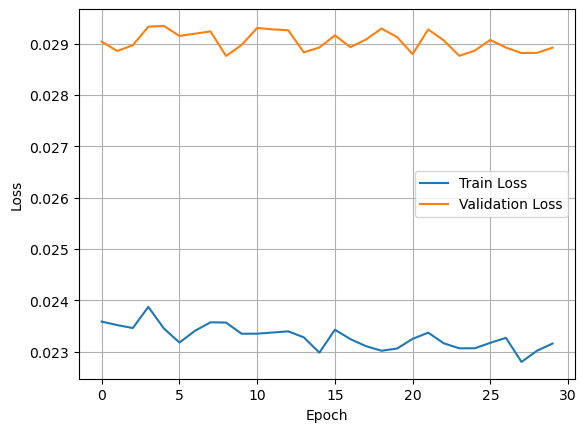

In [152]:
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.grid()
plt.ylabel('Loss')
plt.legend()
plt.show()

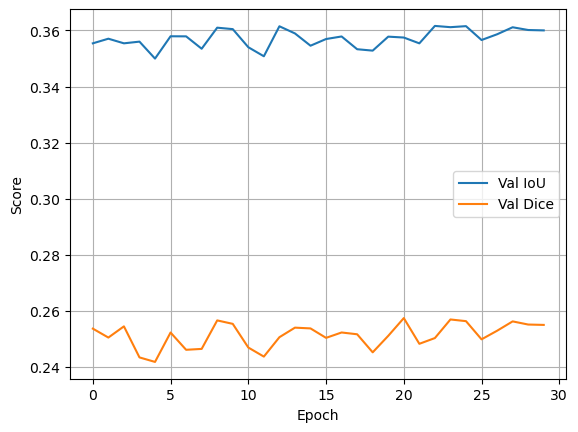

In [153]:
plt.plot(history["val_ious"], label="Val IoU")
plt.plot(history["val_dices"], label="Val Dice")
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid()
plt.legend()
plt.show()


In [154]:
def evaluate(model, test_loader, device, threshold=0.5):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.float32)

            output = model(img)  # logits
            output = torch.sigmoid(output)  # convert logits → probability

            preds.append(output.cpu())
            labels.append(label.cpu())

    # Concatenate all batches
    preds = torch.cat(preds, dim=0)         # shape: [N, 1, 64, 64]
    labels = torch.cat(labels, dim=0)       # shape: [N, 1, 64, 64]

    # Binarize predictions
    binary_preds = (preds >= threshold).float()

    return binary_preds, labels


In [155]:
outputs, labels = evaluate(model, test_loader, device='cuda', threshold=0.45)
outputs = outputs.squeeze(1)
labels = labels.squeeze(1)
outputs = outputs.numpy()
labels = labels.numpy()
print("Predictions shape:", outputs.shape)
print("Labels shape:", labels.shape)


Predictions shape: (226, 64, 64)
Labels shape: (226, 64, 64)


In [156]:
np.max(outputs), np.min(outputs), np.unique(outputs)

(np.float32(1.0), np.float32(0.0), array([0., 1.], dtype=float32))

In [161]:
iou, dice = compute_metrics(torch.tensor(outputs).unsqueeze(1), torch.tensor(labels).unsqueeze(1), threshold=0.45)
print(f"IoU: {iou:.4f}, Dice: {dice:.4f}")

IoU: 0.0131, Dice: 0.0243


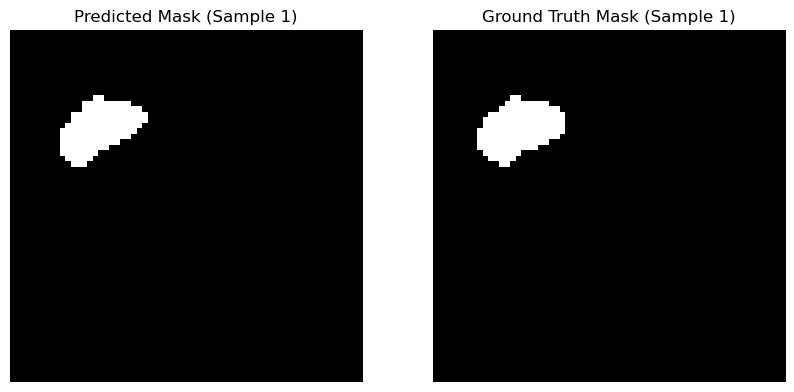

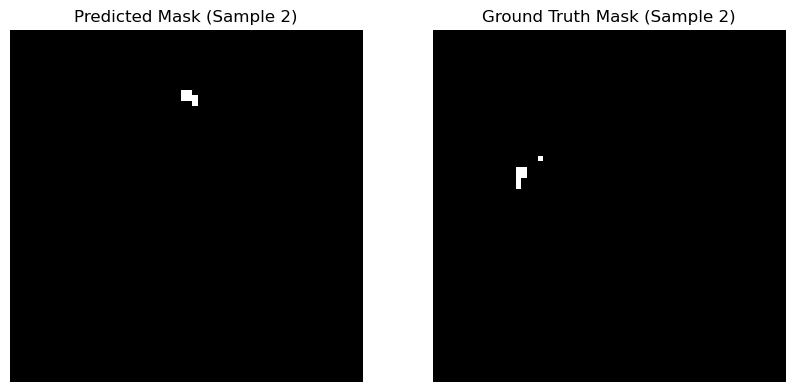

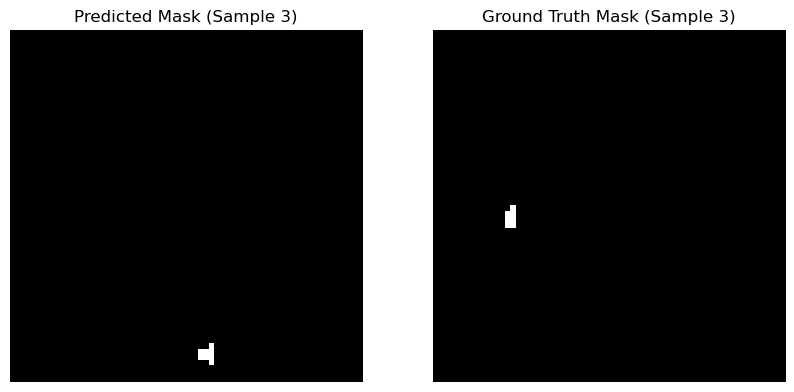

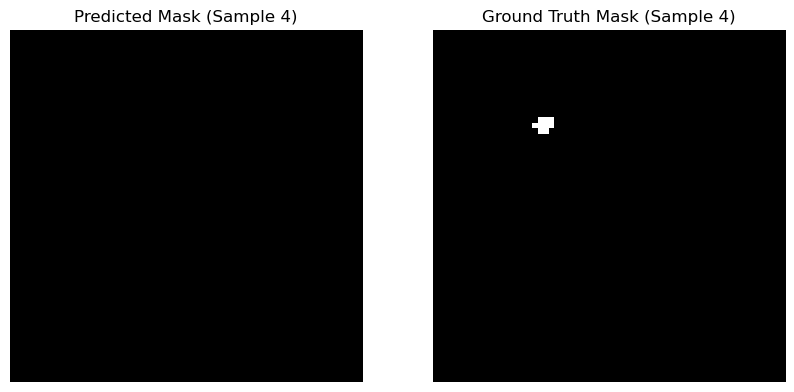

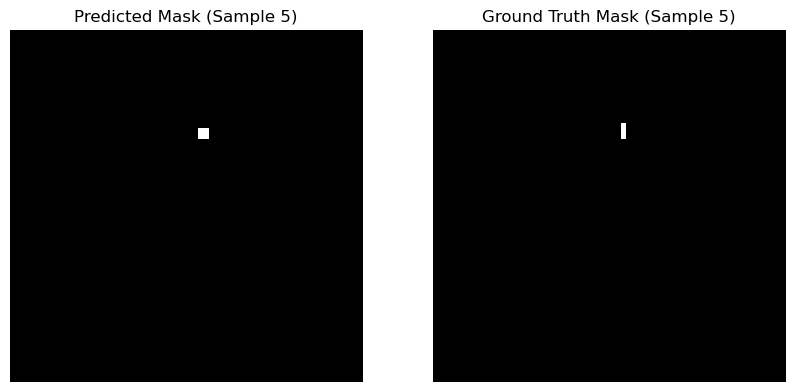

In [147]:
num_samples_to_plot = 5

for i in range(num_samples_to_plot):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(outputs[i], cmap='gray')
    plt.title(f'Predicted Mask (Sample {i+1})')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(labels[i], cmap='gray')
    plt.title(f'Ground Truth Mask (Sample {i+1})')
    plt.axis('off')
    plt.show()

In [ ]:
def compute_dice(y_pred, y_true):
    intersection = np.sum(y_pred * y_true)
    union = np.sum(y_pred) + np.sum(y_true)
    dice = (2.0 * intersection + 1e-8) / (union + 1e-8)
    return dice